In [14]:
import xarray as xr
import rioxarray
import rasterio as rio
from rasterio.crs import CRS
import numpy as np
import os
import re
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
import dask
import time
from hlsstack.hls_funcs import fetch
from hlsstack.hls_funcs.masks import mask_hls, shp2mask, bolton_mask_xr, bolton_mask_np, atsa_mask
from hlsstack.hls_funcs import indices
from hlsstack.hls_funcs.smooth import smooth_xr, despike_ts_xr
import sys
sys.path.insert(1, '../extract')
sys.path.insert(1, '../fit')
from hpc_setup import launch_dask

In [15]:
# cluster location
cluster_loc = 'hpc'

# input path to data or shapfile
inDIR = '../data/ground/'
inFILE = 'ffar-mi-biomass.csv'


inPATH_dat = os.path.join(inDIR, inFILE)
inPATH_shp = '../data/ground/MI_paddock.shp'

# date column name
date_col = 'Date'

# coordinate column names
x_coord_col = 'X_coord'
y_coord_col = 'Y_coord'

# set nickname to shorten path
nickname = 'ffar_mi'

# set output type/units for naming
outunits = 'biomass_kg_ha'

# coordinate reference system (CRS) in ESPG format of the input data
input_epsg = 4326

# coordinate reference system (CRS) in ESPG format of the output data
output_epsg = 32616

# define whether to smooth output
full_smooth = True

# input path to saved model
modPATH = f"../output/models/{nickname}/mod_fnl_mean_biomass_cv_Block_Id_tuneby_Block_Id.pk"

# input path to model metadata dictionary
moddictPATH = f'../output/models/{nickname}/results_fnl_mean_biomass_cv_Block_Id_tuneby_Block_Id.pk'

# output directory
outDIR = f'../data/predictions/{nickname}'

if not os.path.exists(outDIR):
    os.mkdir(outDIR)

# output path basename
if nickname is not None:
    basename =  nickname + '_' + outunits + '.nc'
else:
    basename =  re.sub('.csv', outunits + '.nc', os.path.basename(inPATH))

In [16]:
modPATH

'../output/models/ffar_mi/mod_fnl_mean_biomass_cv_Block_Id_tuneby_Block_Id.pk'

In [17]:
# dictionary specifying functions for each vegetation index to calculate and extract
veg_dict = {
    'NDVI': indices.ndvi_func,
    'DFI': indices.dfi_func,
    'NDTI': indices.ndti_func,
    'SATVI': indices.satvi_func,
    'NDII7': indices.ndii7_func,
    'SAVI': indices.savi_func,
    'RDVI': indices.rdvi_func,
    'MTVI1': indices.mtvi1_func,
    'NCI': indices.nci_func,
    'NDCI': indices.ndci_func,
    'PSRI': indices.psri_func,
    'NDWI': indices.ndwi_func,
    'EVI': indices.evi_func,
    'TCBI': indices.tcbi_func,
    'TCGI': indices.tcgi_func,
    'TCWI': indices.tcwi_func,
    'BAI_126': indices.bai_126_func,
    'BAI_136': indices.bai_136_func,
    'BAI_146': indices.bai_146_func,
    'BAI_236': indices.bai_236_func,
    'BAI_246': indices.bai_246_func,
    'BAI_346': indices.bai_346_func
}

# dictionary specifying individual bands to extract
band_list = ['BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2']

# define full list of model variables
model_vars = [k for k in veg_dict.keys()] + band_list

In [18]:
# df_aoi_txt 

In [19]:
# load csv of ground data
df_aoi_txt = pd.read_csv(inPATH_dat)
# drop any IDs with missing coordinates or IDs
df_aoi_txt = df_aoi_txt.dropna(subset=[x_coord_col, y_coord_col])
# convert date column to date
df_aoi_txt[date_col] = pd.to_datetime(df_aoi_txt[date_col])

# load shapefile of aoi boundaries
gdf_aoi_shp = gpd.read_file(inPATH_shp)

<AxesSubplot:>

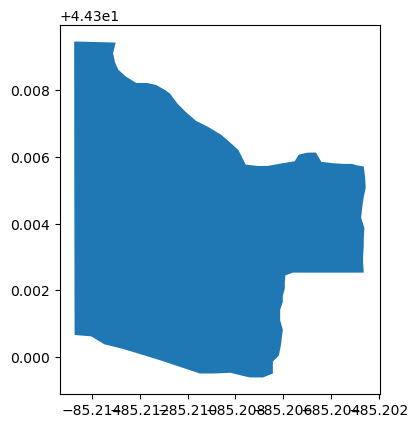

In [20]:
gdf_aoi_shp.plot()

In [21]:
# convert to GeoDataFrame using coordinates
gdf_aoi = gpd.GeoDataFrame(
    df_aoi_txt, geometry=gpd.points_from_xy(df_aoi_txt[x_coord_col], df_aoi_txt[y_coord_col]))
# set the coordinate system
gdf_aoi = gdf_aoi.set_crs(epsg=input_epsg)
gdf_aoi_shp = gdf_aoi_shp.set_crs(epsg=input_epsg)
# reproject to output coordinate system if different
if input_epsg != output_epsg:
    gdf_aoi = gdf_aoi.to_crs(epsg=output_epsg)
    gdf_aoi_shp = gdf_aoi_shp.to_crs(epsg=output_epsg)

In [22]:
bbox_full = np.array(gdf_aoi_shp.buffer(150).total_bounds)

In [23]:
num_jobs=32
from hpc_setup import launch_dask
import psutil
interface_prefs = ['enp24s0f0', 'ens7f0']
interface = [x for x in interface_prefs if x in list(psutil.net_if_addrs().keys())][0]
if len(interface) == 0:
    print('ERROR: Preferred interfaces not found on node!')
else:
    print(interface)
client = launch_dask(cluster_loc=cluster_loc, num_jobs=num_jobs, partition='brief-low', slurm_opts={'interface': interface})
display(client)

enp24s0f0
   setting up cluster on HPC...


/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33649 instead
  warnings.warn(


<Client: 'tcp://10.1.4.115:34247' processes=65 threads=130, memory=302.90 GiB>

In [24]:
try_atsa = True
mask_bolton_by_pixel = False

In [25]:
import pickle

In [26]:
with open(modPATH, 'rb') as f:
    model = pickle.load(f)

/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PLSRegression from version 1.1.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.1.1 when using v

In [27]:
if hasattr(model, 'n_features_in_'):
    print("Model Coefficients:",model.n_features_in_)

Model Coefficients: 28


In [28]:
def pred_mod(dat, model, model_vars, sqrt=True):

    dat_masked = dat.where(dat.notnull())

    def pred_func(*args, mod_vars_np):
        vars_dict_np = {}
        for idx, v in enumerate(mod_vars_np):
            vars_dict_np[v] = args[idx]
        vars_df = pd.DataFrame(vars_dict_np).dropna()
        vars_df = vars_df.rename(columns={col: str(col) for col in vars_df.columns})
        bm_np = np.ones_like(args[0]) * np.nan
        mask = np.any(np.isnan(args), axis=0)
        if len(vars_df) > 0:
            if sqrt:
                preds = model.predict(vars_df).squeeze()
                preds[preds < 0] = 0
                bm_np[~mask] = preds**2
            else:
                preds = model.predict(vars_df).squeeze()
                preds[preds < 0] = 0
                bm_np[~mask] = preds
        return bm_np.astype('int16')

    def pred_func_xr(dat_xr, model_vars_xr):
        dat_xr = dat_xr.stack(z=('y', 'x')).persist()
        dims_list = [['z'] for v in model_vars]
        vars_list_xr = []
        for v in model_vars_xr:
            vars_list_xr.append(dat_xr[v])
        bm_xr = xr.apply_ufunc(pred_func,
                               *vars_list_xr,
                               kwargs=dict(mod_vars_np=np.array(model_vars_xr)),
                               dask='parallelized',
                               vectorize=True,
                               input_core_dims=dims_list,
                               output_core_dims=[dims_list[0]],
                               output_dtypes=['int16'])
        return bm_xr.unstack('z')

    bm_out = pred_func_xr(dat_masked, model_vars)

    return bm_out

def add_variables(xarray_dataset, listofvars):
    data = 0
    for var in listofvars:
        # changed dset to xarray_dataset in the following line
        data = data + xarray_dataset[var]
    return data 


from hlsstack.hls_funcs.smooth import despike_ts, double_savgol

def adapt_smooth(ts, dates, despike=True, dat_thresh=None):
    ct_valid = sum(~np.isnan(ts))
    ct_total = len(ts)
    avg_gap = ct_total/ct_valid
    if ct_valid > 0:
        if avg_gap > 15:
            despike = False
        if despike:
            if dat_thresh is None:
                _dat_thresh = np.ptp(ts) * 0.10
            else:
                _dat_thresh = dat_thresh
            ts_ds = despike_ts(ts, dat_thresh=_dat_thresh, days_thresh=45)
        else:
            ts_ds = ts
        if avg_gap > 10:
            ts_smooth = double_savgol(ts_ds, double=True, window1_max=7, window2=31, limit=91)
        elif avg_gap > 7:
             ts_smooth = double_savgol(ts_ds, double=True, window1_max=5, window2=41, limit=91)
        elif avg_gap > 5:
             ts_smooth = double_savgol(ts_ds, double=True, window1_max=5, window2=51, limit=91)
        else:
            ts_smooth = double_savgol(ts_ds, double=False, window2=51, limit=91)
    else:
        ts_smooth = ts
    return ts_smooth

def adapt_smooth_xr(dat, dims):
    dates = pd.to_datetime(dat.time)
    xr_smoothed = xr.apply_ufunc(adapt_smooth,
                                 dat,
                                 kwargs={'dates': dates, 'despike': True, 'dat_thresh': None},
                                 input_core_dims=[dims],
                                 output_core_dims=[dims],
                                 dask='parallelized', vectorize=True,
                                 output_dtypes=[float])
    return xr_smoothed.transpose('time', 'y', 'x')

In [29]:
start_month = gdf_aoi[date_col][gdf_aoi[date_col].dt.dayofyear.argmin()].month
start_day = gdf_aoi[date_col][gdf_aoi[date_col].dt.dayofyear.argmin()].day
end_month = gdf_aoi[date_col][gdf_aoi[date_col].dt.dayofyear.argmax()].month
end_day = gdf_aoi[date_col][gdf_aoi[date_col].dt.dayofyear.argmax()].day

In [30]:
print('Start date: ' + '-'.join([str(start_month), str(start_day)]))
print('End date: ' + '-'.join([str(end_month), str(end_day)]))

Start date: 5-24
End date: 9-19


In [31]:
tile_size = 300

In [32]:
model_vars

['NDVI',
 'DFI',
 'NDTI',
 'SATVI',
 'NDII7',
 'SAVI',
 'RDVI',
 'MTVI1',
 'NCI',
 'NDCI',
 'PSRI',
 'NDWI',
 'EVI',
 'TCBI',
 'TCGI',
 'TCWI',
 'BAI_126',
 'BAI_136',
 'BAI_146',
 'BAI_236',
 'BAI_246',
 'BAI_346',
 'BLUE',
 'GREEN',
 'RED',
 'NIR1',
 'SWIR1',
 'SWIR2']

In [34]:
# dat_out_ds

In [35]:
xr_pred = dat_out_ds.map_blocks(pred_mod,
                                template=dat_out_ds['NIR1'],
                                kwargs=dict(model=model,
                                            model_vars=model_vars)).where(dat_out_ds['NIR1'].notnull())
xr_pred.name = outunits                                      
                
dat_out_ds[outunits] = xr_pred

NameError: name 'dat_out_ds' is not defined

In [ ]:
x

In [36]:
for yr in gdf_aoi[date_col].dt.year.unique():
    print(yr)
    
    if bbox_full[2] - bbox_full[0] > (30*tile_size):
        x_coords = np.arange(bbox_full[0], bbox_full[2], 30*tile_size)
        x_coords = np.append(x_coords, bbox_full[2])
    else:
        x_coords = [bbox_full[0], bbox_full[2]]
    if bbox_full[3] - bbox_full[1] > (30*tile_size):
        y_coords = np.arange(bbox_full[1], bbox_full[3], 30*tile_size)
        y_coords = np.append(y_coords, bbox_full[3])
    else:
        y_coords = [bbox_full[1], bbox_full[3]]
    
    for xi, x in enumerate(x_coords[:-1]):
        for yi, y in enumerate(y_coords[:-1]):
            minx = x_coords[xi]
            maxx = x_coords[xi+1]
            miny = y_coords[yi]
            maxy = y_coords[yi+1]
            print('Lower left: ', minx, ',', miny)
            if max(len(x_coords), len(y_coords)) > 2:
                outPATH_tmp = os.path.join(outDIR,                                        
                                           re.sub('.nc', 
                                                  '_' + '_'.join([str(yr), str(int(minx)), str(int(miny))]) + '.nc',
                                                  basename))
            else:
                outPATH_tmp = os.path.join(outDIR, re.sub('.nc', '_' + str(yr) + '.nc', basename))
            if os.path.exists(outPATH_tmp):
                print('Prediction already complete for coords. Moving on.')
                continue
            else:
                idx_load_try = 0
                max_load_try = 5
                while idx_load_try < max_load_try:
                    try: 
                        # make sure there are at least some workers before fetching data
                        client.wait_for_workers(n_workers=num_jobs*0.2, timeout=120)

                        # set the start/end dates for analysis
                        start_date = datetime(yr, start_month, start_day) - timedelta(days=60)
                        end_date = datetime(yr, end_month, end_day) + timedelta(days=60)

                        # set the date range for analysis
                        date_rng = pd.date_range(start=start_date, end=end_date)
                        date_rng = date_rng[date_rng <= datetime.today()]

                        # save the date range as a dictionary for fetching
                        data_dict = {'date_range': [str(start_date.date()), 
                                                    str(end_date.date())]}
                        hls_ds = fetch.get_hls(hls_data=data_dict,
                                               bbox=np.array([minx, miny, maxx, maxy]), 
                                               stack_chunks=(1, -1, 450, 450),
                                               debug=False,
                                               proj_epsg=gdf_aoi.crs.to_epsg(),
                                               lim=1000,
                                               aws=False)
                        hls_ds = hls_ds.assign_coords(tile_id = ('time', [x.split('.')[2] for x in hls_ds['id'].values]))
                        hls_ds.sortby('time')
                        hls_ds = hls_ds.load()
                        idx_load_try = max_load_try
                    except rio.errors.RasterioIOError:
                        if idx_load_try == max_load_try:
                            print('Fetching HLS failed for the max number of tries. Ending.')
                            break
                        else:
                            print('Warning: error loading data. Retrying ' + str(idx_load_try+1) + ' of ' + str(max_load_try))
                            client.restart()
                            idx_load_try += 1   
                    except RuntimeError:
                        if idx_load_try == max_load_try:
                            print('Fetching HLS failed for the max number of tries. Ending.')
                            break
                        else:
                            print('Warning: error loading data. Retrying ' + str(idx_load_try+1) + ' of ' + str(max_load_try))
                            client.restart()
                            idx_load_try += 1   

                # mask out any negative reflectance values for bands
                negval_mask = add_variables((hls_ds[band_list] < 0), band_list)
                hls_ds = hls_ds.where(negval_mask == 0)
                
                # create a tile ID coordinate
                hls_ds = hls_ds.assign_coords(tile_id = ('time', [x.split('.')[2] for x in hls_ds['id'].values]))
                
                # pick best image for any dates with duplicate images for the same tile
                if len(hls_ds['time'].groupby('tile_id').apply(lambda x: x.drop_duplicates('time', False))) < len(hls_ds['time']):
                    print('Dropping duplicate images for same tile.')
                    hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['all'])
                    hls_ds['maskcov_pct'] = ((hls_mask != 0).sum(['y', 'x']) / hls_ds['FMASK'].isel(time=0).size * 100)#
                    hls_ds = hls_ds.groupby('tile_id').apply(lambda x: x.sortby('maskcov_pct').drop_duplicates('time', keep='first')).sortby('time').compute()
                
                # merge and drop tile_id if multiple tiles exist, but don't overlap
                if 'tile_id' in hls_ds.coords and \
                len(np.unique(hls_ds.tile_id.values)) > 1 and \
                len(np.unique(hls_ds.drop_duplicates(dim=['time', 'y', 'x'])['time'])) < len(np.unique(hls_ds['time'])):
                    print('Multiple, overlapping tiles ids still exist for the same date. Need to figure out how to deal with this and keep mask intact.')
                elif 'tile_id' in hls_ds.coords and len(np.unique(hls_ds.tile_id.values)) > 1:
                    print('Dropping tile_id by taking mean across time dimension.')
                    hls_ds = hls_ds.groupby('time').mean()
                
                display(hls_ds)
                
                # compute ATSA mask if possible
                if try_atsa:
                    print('masking out clouds and shadows detected by ATSA')
                    if len(np.unique(hls_ds.drop_duplicates(dim=['time', 'y', 'x'])['time'])) < len(np.unique(hls_ds['time'])):
                        print('Overlapping tiles found. Computing masks separately by tile id.')
                        hls_atsa = hls_ds.groupby('tile_id').apply(lambda x: atsa_mask(x.where(
                            x['BLUE'].notnull(), drop=True))).compute()
                        hls_atsa = hls_atsa.transpose('time', 'y', 'x')
                        mask_atsa = True
                    else:
                        hls_ds = hls_ds.reset_coords(drop=True)
                        try:
                            hls_atsa = atsa_mask(hls_ds).compute()
                            mask_atsa = True
                        except ValueError or IndexError:
                            print('WARNING: Could not compute ATSA cloud/shadow mask')
                            mask_atsa = False
                            pass
                else:
                    mask_atsa = False
                
                if mask_bolton_by_pixel:
                    # compute the bolton mask
                    hls_bolton_mask = bolton_mask(hls_ds).compute()
                    hls_ds = xr.merge([hls_ds, hls_atsa], join='inner')
                    hls_ds.where(hls_ds['BOLTON'] == 0, drop=True)
                
                # compute native HLS mask, including all aerosol flags
                hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['cirrus',
                                                                 'cloud',
                                                                 'cloud_adj',
                                                                 'shadow', 
                                                                 'snow',
                                                                 'water',
                                                                 'high_aerosol'])
                # mask water where more than 50% of dates are classified as water
                hls_water_mask = mask_hls(hls_ds['FMASK'], mask_types=['water'])
                hls_water_mask = (hls_water_mask.sum(dim=['time']) > len(hls_ds['time'])*.50).astype('int')
                
                # mask using native HLS mask
                hls_ds = hls_ds.where(hls_mask == 0)
                
                # mask using ATSA mask, if available
                if mask_atsa:
                    print('Applying ATSA mask to dataset.')
                    # merge ATSA mask with HLS data
                    hls_ds = xr.merge([hls_ds, hls_atsa], join='inner')
                    hls_ds = hls_ds.where(hls_ds['ATSA'] == 1)
                
                # in case multiple tile_id's still exist, take the mean by pixel
                if 'tile_id' in hls_ds.coords and \
                len(np.unique(hls_ds.tile_id.values)) > 1 and \
                len(np.unique(hls_ds.drop_duplicates(dim=['time', 'y', 'x'])['time'])) < len(np.unique(hls_ds['time'])):
                    print('Multiple, overlapping tiles ids still exist, taking mean by pixel for each date')
                    hls_ds = hls_ds.groupby('time').mean()

                # lazy compute all vegetation indices
                for vegidx in veg_dict:
                    hls_ds[vegidx] = veg_dict[vegidx](hls_ds)
                
                print('   creating daily template for output...')
                # reset date range to be within dataset
                date_rng = np.array([x.date() for x in date_rng])
                date_rng = date_rng[(date_rng <= hls_ds['time'].max().values) & (date_rng >= hls_ds['time'].min().values)]
                
                # create an output Dataset template with all dates
                dat_out = xr.Dataset(coords={'time': [x for x in date_rng if x not in hls_ds['time'].values],
                                             'x': hls_ds.x,
                                             'y': hls_ds.y})
                
                t1 = time.time() 
                
                # create full time series for each vegetation index and band
                for idx, b in enumerate(list(veg_dict.keys()) + band_list):
                    dat_out_nans = np.zeros((dat_out.dims['time'], 
                                             dat_out.dims['y'], 
                                             dat_out.dims['x'])) * np.nan
                
                    dat_out = dat_out.assign(b=(['time', 'y', 'x'],
                                                     dat_out_nans))   
                    dat_out = dat_out.rename({'b': b})
                    if idx == 0:
                        dat_out_ds = xr.concat([dat_out[b], hls_ds[b]], dim='time').to_dataset() 
                        #dat_out_ds = dat_out_ds.sortby('time')
                        dat_out_ds = dat_out_ds.rio.write_crs(CRS.from_dict(init='epsg:' + str(output_epsg)))
                    else:
                        dat_out_ds[b] = xr.concat([dat_out[b], hls_ds[b]], dim='time')
                
                dat_out_ds = dat_out_ds.sortby('time').chunk({'time': -1, 'y': 20, 'x': 20})

                print('   interpolating and smoothing inputs')
                # lazy smooth all vegetation indices and bands
                for b in list(veg_dict.keys()) + band_list:
                    dat_out_ds[b] = adapt_smooth_xr(dat_out_ds[b], 
                                                    dims=['time'])


                print('   predicting')
                # create predicted array
                xr_pred = dat_out_ds.map_blocks(pred_mod, 
                                                template=dat_out_ds['NIR1'],
                                                kwargs=dict(model=model, 
                                                            model_vars=model_vars)).where(dat_out_ds['NIR1'].notnull())
                xr_pred.name = outunits                                      
                
                dat_out_ds[outunits] = xr_pred
                
                if full_smooth:
                    dat_out_da = despike_ts_xr(dat_out_ds[outunits],
                                               dat_thresh=150, 
                                               mask_outliers=True,
                                               z_thresh=5.0,
                                               iters=2,
                                               dims=['time'])
                    dat_out_da = smooth_xr(dat_out_da, 
                                           dims=['time'], 
                                           kwargs={'double': False, 'window2': 31, 'limit': 91})
                else:
                    dat_out_da = dat_out_ds[outunits].interpolate_na('time').rolling(time=21, 
                                                                                      center=True,
                                                                                      min_periods=1).mean()
                
                # create mask for within the current year in case date range extends into previous/future years
                yr_mask = dat_out_ds['time'].astype(np.datetime64).dt.year == yr
                
                # compute output for within the current year. NOTE: reproject or float type required to keep coordinates for netcdf output?
                dat_out_da = dat_out_da.sel(time=yr_mask).to_dataset().astype('float32').rio.reproject("EPSG:" + str(output_epsg)).compute()
                dat_out_da = dat_out_da.rio.write_crs("epsg:" + str(output_epsg))
                dat_out_da = dat_out_da.sortby(["time", "y", "x"])
                
                # mask out water
                dat_out_da = dat_out_da.where(hls_water_mask == 0)
                
                # rename time to date
                dat_out_da = dat_out_da.rename({'time': 'date'})
                
                # change to datetime as required for saving to netcdf
                dat_out_da['date'] = dat_out_da['date'].astype(np.datetime64)
                
                # delete output if it already exists
                if os.path.exists(outPATH_tmp):
                    os.remove(outPATH_tmp)
                # save output to disk
                dat_out_da.to_netcdf(outPATH_tmp)
                # set permissions to be read/write/execute for all users
                os.chmod(outPATH_tmp, 0o777)
                
                print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')

                # delete datasets to free memory
                del hls_ds, dat_out_da, dat_out_ds, dat_out, dat_out_nans
                
                if mask_atsa:
                    del hls_atsa
        
                client.restart()

2022
Lower left:  642235.7768904634 , 4906539.372341662
Dropping duplicate images for same tile.


<xarray.Dataset>
Dimensions:         (time: 94, y: 48, x: 44)
Coordinates:
  * time            (time) object 2022-03-28 2022-04-10 ... 2022-11-13
    id              (time) <U34 'HLS.S30.T16TFQ.2022087T162829.v2.0' ... 'HLS...
  * x               (x) float64 6.422e+05 6.422e+05 ... 6.435e+05 6.435e+05
  * y               (y) float64 4.908e+06 4.908e+06 ... 4.907e+06 4.907e+06
    eo:cloud_cover  (time) int64 94 4 90 100 85 100 36 ... 0 0 30 99 59 42 98
    epsg            int64 32616
    tile_id         (time) <U6 'T16TFQ' 'T16TFQ' 'T16TFQ' ... 'T16TFQ' 'T16TFQ'
Data variables:
    BLUE            (time, y, x) float64 1.889e+03 1.648e+03 ... 8.741e+03
    GREEN           (time, y, x) float64 1.862e+03 1.646e+03 ... 8.762e+03
    RED             (time, y, x) float64 1.92e+03 1.709e+03 ... 8.508e+03
    NIR1            (time, y, x) float64 2.461e+03 2.114e+03 ... 8.676e+03
    SWIR1           (time, y, x) float64 599.0 594.0 ... 4.839e+03 5.302e+03
    SWIR2           (time, y, x) float64 571.0 592.0 ... 3.325e+03 3.656e+03
    FMASK           (time, y, x) float64 194.0 194.0 194.0 ... 194.0 194.0 194.0
    SZA             (time, y, x) float64 4.354e+03 4.354e+03 ... 6.317e+03
    SAA             (time, y, x) float64 1.562e+04 1.562e+04 ... 1.683e+04
    VZA             (time, y, x) float64 542.0 542.0 542.0 ... 526.0 525.0 525.0
    VAA             (time, y, x) float64 9.139e+03 9.139e+03 ... 9.104e+03
    maskcov_pct     (time) float64 100.0 0.6155 100.0 ... 88.12 19.27 100.0
Attributes:
    spec:        RasterSpec(epsg=32616, bounds=(642210, 4906530, 643530, 4907...
    crs:         epsg:32616
    transform:   | 30.00, 0.00, 642210.00|\n| 0.00,-30.00, 4907970.00|\n| 0.0...
    resolution:  30

masking out clouds and shadows detected by ATSA


/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


HOT centers of clear, thin and thick cloudy pixels on land : [ 159.57623126 1210.30936487 2372.95512114]


/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/hlsstack/utils/atsa_utils.py:637: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  center_class = KMeans(n_clusters=num_cluster, n_init=50, random_state=0).fit(sample_shadow.reshape(-1, 1))


Shadow index centers of shadow, nonshadow dark and nonshadow bright on land : [2094. 2094. 2094.]
Applying ATSA mask to dataset.
   creating daily template for output...
   interpolating and smoothing inputs
   predicting
...completed in 27.0 secs
2023
Lower left:  642235.7768904634 , 4906539.372341662
Dropping duplicate images for same tile.


<xarray.Dataset>
Dimensions:         (time: 100, y: 48, x: 44)
Coordinates:
  * time            (time) object 2023-03-26 2023-03-28 ... 2023-11-16
    id              (time) <U34 'HLS.L30.T16TFQ.2023085T162146.v2.0' ... 'HLS...
  * x               (x) float64 6.422e+05 6.422e+05 ... 6.435e+05 6.435e+05
  * y               (y) float64 4.908e+06 4.908e+06 ... 4.907e+06 4.907e+06
    eo:cloud_cover  (time) int64 0 6 82 85 12 46 99 0 ... 94 62 100 84 55 11 100
    epsg            int64 32616
    tile_id         (time) <U6 'T16TFQ' 'T16TFQ' 'T16TFQ' ... 'T16TFQ' 'T16TFQ'
Data variables:
    BLUE            (time, y, x) float64 9.616e+03 7.903e+03 ... 265.0 348.0
    GREEN           (time, y, x) float64 9.449e+03 7.806e+03 ... 462.0 493.0
    RED             (time, y, x) float64 9.448e+03 7.81e+03 ... 613.0 704.0
    NIR1            (time, y, x) float64 8.482e+03 7.075e+03 ... 2.334e+03
    SWIR1           (time, y, x) float64 435.0 694.0 ... 1.896e+03 2.136e+03
    SWIR2           (time, y, x) float64 561.0 724.0 ... 1.347e+03 1.49e+03
    FMASK           (time, y, x) float64 208.0 208.0 208.0 ... 194.0 194.0 194.0
    SZA             (time, y, x) float64 4.601e+03 4.601e+03 ... 6.357e+03
    SAA             (time, y, x) float64 1.499e+04 1.499e+04 ... 1.709e+04
    VZA             (time, y, x) float64 570.0 570.0 ... 1.057e+03 1.057e+03
    VAA             (time, y, x) float64 1.011e+04 1.011e+04 ... 2.941e+04
    maskcov_pct     (time) float64 99.05 96.02 69.27 ... 99.57 0.3788 100.0
Attributes:
    spec:        RasterSpec(epsg=32616, bounds=(642210, 4906530, 643530, 4907...
    crs:         epsg:32616
    transform:   | 30.00, 0.00, 642210.00|\n| 0.00,-30.00, 4907970.00|\n| 0.0...
    resolution:  30

masking out clouds and shadows detected by ATSA


/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


HOT centers of clear, thin and thick cloudy pixels on land : [ 187.33924846 1413.77084012 2924.47315555]


/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/hlsstack/utils/atsa_utils.py:637: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  center_class = KMeans(n_clusters=num_cluster, n_init=50, random_state=0).fit(sample_shadow.reshape(-1, 1))


Shadow index centers of shadow, nonshadow dark and nonshadow bright on land : [2140.9577182 2140.9577182 2140.9577182]
Applying ATSA mask to dataset.
   creating daily template for output...
   interpolating and smoothing inputs
   predicting
...completed in 23.0 secs


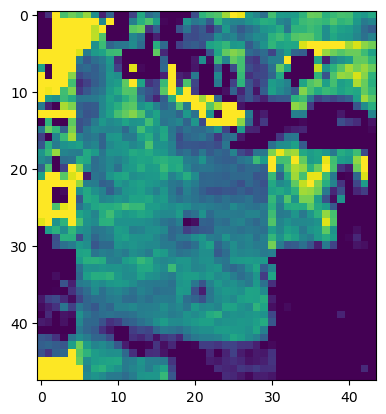

<AxesSubplot:>

In [38]:
from rasterio.plot import show
dat = rioxarray.open_rasterio(outPATH_tmp)
show(dat.isel(date=50)['biomass_kg_ha'].data, vmin=800, vmax=4000)

In [ ]:
dat.isel(x=slice(20, 40),
         y=slice(60, 80))['biomass_kg_ha'].mean(dim=('y', 'x'))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(dat.isel(x=slice(20, 40),
         y=slice(60, 80))['biomass_kg_ha'].mean(dim=('y', 'x')))

In [ ]:
for i in hls_ds.data_vars:
    if i == 'FMASK':
        hls_ds[i] = hls_ds[i].astype('uint8')
    elif i in ['SZA', 'SAA', 'VZA', 'VAA']:
        hls_ds[i] = hls_ds[i].astype('uint16')
    elif i == 'maskcov_pct':
        hls_ds[i] = hls_ds[i].astype('float32')
    else:
        hls_ds[i] = hls_ds[i].astype('int16')

In [ ]:
hls_ds.reset_coords(drop=True)

In [ ]:
# compute ATSA mask if possible
if try_atsa:
    print('masking out clouds and shadows detected by ATSA')
    if len(np.unique(hls_ds.drop_duplicates(dim=['time', 'y', 'x'])['time'])) < len(np.unique(hls_ds['time'])):
        print('Overlapping tiles found. Computing masks separately by tile id.')
        hls_atsa = hls_ds.groupby('tile_id').apply(lambda x: atsa_mask(x.where(
            x['BLUE'].notnull(), drop=True))).compute()
        hls_atsa = hls_atsa.transpose('time', 'y', 'x')
        mask_atsa = True
    else:
        hls_ds = hls_ds.reset_coords(drop=True)
        try:
            hls_atsa = atsa_mask(hls_ds).compute()
            mask_atsa = True
        except ValueError or IndexError:
            print('WARNING: Could not compute ATSA cloud/shadow mask')
            mask_atsa = False
            pass
else:
    mask_atsa = False